# Image Operations
Here is the list of the image operations implemented:
- Histogram Equalization
- Adaptive Histogram Equalization
- Image Thresholding
- Adaptive Thresholding
- Otsu's Thresholding
- Gaussian Blurring
- Laplacian Filter
- Laplacian of Gaussian Filter
- Canny Edge Detection
- Hough Transform of Lines
- Hough Transform of Circles
- GrabCut

In [0]:
!pip install tensorflow-gpu==2.0.0-beta1
!pip install python-igraph

In [0]:
import tensorflow as tf
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import math
import time
from sklearn.mixture import GaussianMixture
import igraph

In [0]:
!wget https://i.stack.imgur.com/ixxVt.jpg
!wget http://webresizer.com/images2/bird1_after.jpg
!wget https://www.akg-images.co.uk/Docs/AKG/Media/TR3_WATERMARKED/5/e/d/6/AKG150401.jpg
!wget https://i.ytimg.com/vi/UU89SxQoFRA/hqdefault.jpg
!wget https://c8.alamy.com/comp/DX0EK6/red-apple-fruit-against-light-blue-background-single-object-square-DX0EK6.jpg
!wget https://cdn.pixabay.com/photo/2016/11/18/17/46/architecture-1836070__340.jpg

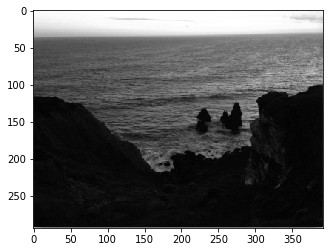

In [6]:
i1 = Image.open('./ixxVt.jpg')
color = np.array(i1)

shape = color.shape
if max(shape[0],shape[1])>600:
    shape = [int(color.shape[0]/2),int(color.shape[1]/2)]
color = np.array(Image.fromarray(color).resize((shape[1],shape[0]), Image.ANTIALIAS))
gray = np.array(i1.convert('L'))
gray = np.array(Image.fromarray(gray).resize((shape[1],shape[0]), Image.ANTIALIAS))
plt.imshow(gray,cmap='gray')

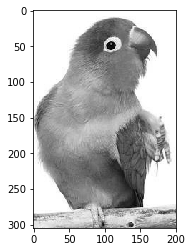

In [7]:
i1 = Image.open('./bird1_after.jpg')
color1 = np.array(i1)

shape = color1.shape
if max(shape[0],shape[1])>600:
    shape = [int(color1.shape[0]/2),int(color1.shape[1]/2)]
color1 = np.array(Image.fromarray(color1).resize((shape[1],shape[0]), Image.ANTIALIAS))
gray1 = np.array(i1.convert('L'))
gray1 = np.array(Image.fromarray(gray1).resize((shape[1],shape[0]), Image.ANTIALIAS))
plt.imshow(gray1,cmap='gray')

In [7]:
i1 = Image.open('./AKG150401.jpg')
color2 = np.array(i1)

shape = color2.shape
if max(shape[0],shape[1])>600:
    shape = [int(color2.shape[0]/2),int(color2.shape[1]/2)]
color2 = np.array(Image.fromarray(color2).resize((shape[1],shape[0]), Image.ANTIALIAS))
gray2 = np.array(i1.convert('L'))
gray2 = np.array(Image.fromarray(gray2).resize((shape[1],shape[0]), Image.ANTIALIAS))
plt.imshow(gray2,cmap='gray')

In [8]:
i1 = Image.open('./hqdefault.jpg')
color3 = np.array(i1)

shape = color3.shape
if max(shape[0],shape[1])>600:
    shape = [int(color3.shape[0]/2),int(color3.shape[1]/2)]
color3 = np.array(Image.fromarray(color3).resize((shape[1],shape[0]), Image.ANTIALIAS))
gray3 = np.array(i1.convert('L'))
gray3 = np.array(Image.fromarray(gray3).resize((shape[1],shape[0]), Image.ANTIALIAS))
plt.imshow(gray3,cmap='gray')

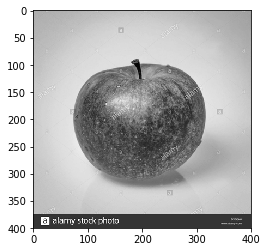

In [9]:
i1 = Image.open('./red-apple-fruit-against-light-blue-background-single-object-square-DX0EK6.jpg')
color4 = np.array(i1)

shape = color4.shape
if max(shape[0],shape[1])>600:
    shape = [400,400]
color4 = np.array(Image.fromarray(color4).resize((shape[1],shape[0]), Image.ANTIALIAS))
gray4 = np.array(i1.convert('L'))
gray4 = np.array(Image.fromarray(gray4).resize((shape[1],shape[0]), Image.ANTIALIAS))
plt.imshow(gray4,cmap='gray')

In [50]:
i1 = Image.open('./architecture-1836070__340.jpg')
color5 = np.array(i1)

shape = color5.shape
if max(shape[0],shape[1])>600:
    shape = [int(color5.shape[0]/2),int(color5.shape[1]/2)]
color5 = np.array(Image.fromarray(color5).resize((shape[1],shape[0]), Image.ANTIALIAS))
gray5 = np.array(i1.convert('L'))
gray5 = np.array(Image.fromarray(gray5).resize((shape[1],shape[0]), Image.ANTIALIAS))
plt.imshow(gray5,cmap='gray')

## Histogram Equaliazation
Histogram equalization is a technique for adjusting image intensities to enhance contrast.</br>
It creates histogram of pixel intensity and then after calculating cumulative sum of the histogram mapping from old pixel value to new value is done and the output is a histogram equalized image.

In [0]:
def histogran_equalization(image):
    if len(image.shape)==3 and image.shape[2]==3: # convert rgb to grayscale
        image = tf.image.convert_image_dtype(image, tf.dtypes.float32)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.convert_image_dtype(image, tf.dtypes.int32)
        image = tf.squeeze(image,2)
    
    image = tf.convert_to_tensor(image, tf.int32)
    
    rows, cols = image.shape[0], image.shape[1]
    histogram = tf.math.bincount(image, dtype=tf.int32)
    
    cumsum = tf.cumsum(histogram)
    sk = tf.cast((255 * cumsum)/cumsum[-1], tf.int32)

    final = tf.nn.embedding_lookup(sk, image)
    return final

In [11]:
t0 = time.time()
histogram = histogran_equalization(gray)
print("Time: ",time.time()-t0)
plt.title("Result of histogram equalization")
plt.imshow(histogram, cmap='gray')

Time:  0.045594215393066406


## Contrast Limited Adaptive Histogram Equalization
Contrast limited adaptive histogram equalization differs from simple Histogram Equalization as it adapts to local changes in contrast and along with this it prevents the over amplification noise cause due to equalization in small local regions .</br>
Here input is image and the clip limit

In [0]:
def interpolate(subBin,LU,RU,LB,RB,subX,subY):
    subImage = np.zeros(subBin.shape)
    num = subX*subY
    for i in range(subX):
        inverseI = subX-i
        for j in range(subY):
            inverseJ = subY-j
            val = subBin[i,j].astype(int)
            subImage[i,j] = np.floor((inverseI*(inverseJ*LU[val] + j*RU[val])+ i*(inverseJ*LB[val] + j*RB[val]))/num)
    return subImage

In [0]:
def adaptive_histogram(image,clipLimit,nrBins=128):
    img = tf.convert_to_tensor(image, tf.int32)
    h,w = img.shape
    nrBins = max(nrBins,128)

    xsz, ysz = 32,32
    nrX = int(tf.math.ceil(h/xsz))
    nrY = int(tf.math.ceil(w/ysz))
    hist = tf.Variable(np.zeros((nrX,nrY,nrBins), dtype=np.int32))

    excX = int(xsz*(nrX-h/xsz))
    excY = int(ysz*(nrY-w/ysz))
    paddings = tf.constant([[0,excX], [0,excY]])
    img = tf.pad(img, paddings,'constant')
    
    nrPixels = xsz*ysz
    finalimg = np.zeros(img.shape)
    
    clipLimit = int(max(1.0,clipLimit*xsz*ysz/nrBins))
    
    bins = tf.math.floor(img.numpy()/2)
    bins = tf.cast(bins, tf.int32)

    for i in range(nrX):
        for j in range(nrY):
            bin_ = bins[i*xsz:(i+1)*xsz,j*ysz:(j+1)*ysz]
            t_hist = tf.math.bincount(bin_,dtype=tf.int32)
            hist = hist[i,j,:len(t_hist)].assign(t_hist)
    
    for i in range(nrX):
        for j in range(nrY):
            nrExcess = 0
            excess = tf.subtract(hist[i,j], clipLimit)
            excess = tf.where(excess<0,0,excess)
            nrExcess = tf.reduce_sum(excess)
            
            binIncr = tf.cast(nrExcess/nrBins,dtype=tf.int32)
            upper = tf.subtract(clipLimit, binIncr)

            l = hist[i,j]
            res = tf.where(l>int(clipLimit), clipLimit, l)
            res = tf.where((l>int(upper)) & (l<=int(clipLimit)), clipLimit, res)
            res = tf.where(l<=int(upper), tf.add(l,binIncr), res)
            
            lwr = tf.reduce_mean(tf.where(l<=int(upper), 1, 0))
            mid = tf.reduce_mean(tf.where((l>int(upper)) & (l<=int(clipLimit)), 1, 0))
            midv = tf.reduce_mean(tf.where((l>int(upper)) & (l<=int(clipLimit)), l, 0))            
            nrExcess += mid*upper - midv - binIncr*lwr

            hist = hist[i,j].assign(l)

            if int(nrExcess) > 0:
                stepSz = int(max(1,np.floor(1+nrExcess/nrBins)))
                for nr in range(nrBins):
                    nrExcess = tf.subtract(nrExcess, stepSz)
                    hist = hist[i,j,nr].assign(tf.add(hist[i,j,nr], stepSz))
                    if int(nrExcess) < 1:
                        break

    map_ = np.zeros((nrX,nrY,nrBins))
    scale = 255/nrPixels
    sum_ = 0
    hist = hist.numpy()
    bins = bins.numpy()
    for nr in range(nrBins):
        sum_ += hist[:,:,nr]
        map_[:,:,nr] = np.floor(np.minimum(sum_*scale,255*np.ones((nrX,nrY))))
    
    xI = 0
    for i in range(nrX+1):
        subX = int(xsz/2) if (i==0 or i==nrX) else xsz
        xU, xB = i-1,i
        if xU<0: xU = 0
        if xB>nrX-1: xB = nrX-1
        
        yI = 0
        for j in range(nrY+1):
            subY = int(ysz/2) if (j==0 or j==nrY) else ysz
            yL, yR = j-1,j
            if yL<0: yL = 0
            if yR>nrY-1: yR = nrY-1

            UL = map_[xU,yL,:]
            UR = map_[xU,yR,:]
            BL = map_[xB,yL,:]
            BR = map_[xB,yR,:]

            subBin = bins[xI:xI+subX,yI:yI+subY]
            subImage = interpolate(subBin,UL,UR,BL,BR,subX,subY)
            finalimg[xI:xI+subX,yI:yI+subY] = subImage
            yI += subY
        xI += subX
    
    if excX==0 and excY!=0:
        return finalimg[:,:-excY]
    elif excX!=0 and excY==0:
        return finalimg[:-excX,:]
    elif excX!=0 and excY!=0:
        return finalimg[:-excX,:-excY]
    else:
        return finalimg

In [158]:
t0 = time.time()
ada_hist = adaptive_histogram(gray,8)
print("Time: ",time.time()-t0)
plt.title("Result of Adaptive histogram equalization")
plt.imshow(ada_hist, cmap='gray')

Time:  5.206202030181885


## Image Thresholding

In [0]:
def basic_threshold(image, threshold):
    image = tf.convert_to_tensor(image, name="image")

    rank = image.shape.rank
    if rank != 2 and rank != 3:
        raise ValueError("Image should be either 2 or 3-dimensional.")

    if not isinstance(threshold,int):
        raise ValueError("Threshold value must be an integer.")

    if rank == 3:
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.convert_image_dtype(image, tf.dtypes.uint8)
        image = tf.squeeze(image,2)

    final = tf.where(image>threshold,255,0)
    return final

In [9]:
thresh1 = basic_threshold(gray1, 100)
plt.title("Results of Basic Image Thresholding")
plt.imshow(thresh1,cmap='gray')

## Adaptive Thresholding

In [0]:
def adaptive_thresholding(image):
    if len(image.shape)==3 and image.shape[2]==3:
        raise TypeError('Please input Grayscaled Image.')
    elif len(image.shape)>3:
        raise TypeError('Incorrect number of channels.')
    r, c = image.shape
    window = 40
    
    i = 0
    final = np.zeros((r,c))
    while i<r:
        j = 0
        r1 = min(i+window, r)
        while j<c:
            c1 = min(j+window, c)
            cur = image[i:r1,j:c1]
            thresh = np.mean(np.mean(cur,axis=0))
            res = tf.reshape(cur,[-1])
            res = tf.map_fn(lambda x:0 if x<int(thresh) else 255, res, dtype=tf.int32)
            res = tf.reshape(res,[cur.shape[0],cur.shape[1]])
            final[i:r1,j:c1] = res
            j += window
        i += window
    return final

In [12]:
thresh2 = adaptive_thresholding(gray1)
plt.title("Results of Adaptive Image Thresholding")
plt.imshow(thresh2,cmap='gray')

## Otsu's Thresholding

In [0]:
def otsu_thresholding(image):
    image = tf.convert_to_tensor(image, name="image")

    rank = image.shape.rank
    if rank != 2 and rank != 3:
        raise ValueError("Image should be either 2 or 3-dimensional.")

    if image.dtype!=tf.int32:
        image = tf.cast(image, tf.int32)

    r, c = image.shape
    hist = tf.math.bincount(image, dtype=tf.int32)

    current_max, threshold = 0, 0
    total = r * c

    spre = [0]*256
    sw = [0]*256
    spre[0] = int(hist[0])

    for i in range(1,256):
        spre[i] = spre[i-1] + int(hist[i])
        sw[i] = sw[i-1]  + (i * int(hist[i]))

    for i in range(256):
        if total - spre[i] == 0:
            break

        meanB = sw[i]/spre[i]
        meanF = (sw[255] - sw[i])/(total - spre[i])
        varBetween = (total - spre[i]) * spre[i] * ((meanB-meanF)**2)

        if varBetween > current_max:
            current_max = varBetween
            threshold = i

    final = tf.where(image>threshold,255,0)
    return final

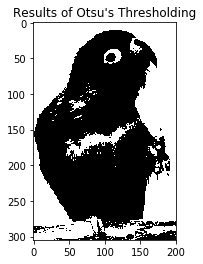

In [14]:
thresh3 = otsu_thresholding(gray1)
plt.title("Results of Otsu's Thresholding")
plt.imshow(thresh3,cmap='gray')

## Gaussian Blurring
In Gaussian Blur, the image is convolved with a Gaussian filter instead of the box filter used in mean filter. The Gaussian filter is a low-pass filter that removes the high-frequency components are reduced.</br>
Example of a gaussian filter: 

![alt text](https://4.bp.blogspot.com/-v4dH8qhFnEE/WqHaTPel8RI/AAAAAAAAI8g/AxIVu5i7mHU5UDcu6BkJQJj_UO11sMomwCLcBGAs/s1600/3x3%2BGaussian%2BKernel.png)

Here input for this operation is image, filter size and sigma value for the gaussian.

In [0]:
def gaussFilter(fx, sigma):
    x = tf.range(-int(fx/2), int(fx/2)+1, 1)
    y = x
    Y, X = tf.meshgrid(x, y)
    
    sigma = -2*(sigma**2)
    z = tf.cast(tf.add(tf.square(X), tf.square(Y)),tf.float64)
    k = 2*tf.exp(tf.divide(z,sigma))
    k = tf.divide(k,tf.reduce_sum(k))
    return k

In [0]:
def gaussian_Blur(image, filtersize, sigma):
    fx = filtersize
    if len(image.shape) == 3 and image.shape[2] != 3:
        raise TypeError('Incorrect number of channels.')
    
    elif len(image.shape) == 3 and image.shape[2] == 3:
        image = tf.pad(image, [[int(fx/2),int(fx/2)],[int(fx/2),int(fx/2)],[0,0]], "REFLECT")
        n_channels = 3
    
    elif len(image.shape) == 2:
        image = tf.pad(image, [[int(fx/2),int(fx/2)],[int(fx/2),int(fx/2)]], "REFLECT")
        image = tf.expand_dims(image, 2)
        n_channels = 1
    
    fil = gaussFilter(fx, sigma)
    
    fil = tf.stack([fil]*n_channels, axis=2)
    
    fil = tf.expand_dims(fil, 3)
    
    new = tf.image.convert_image_dtype(image, tf.float64)
    new = tf.expand_dims(new, 0)
    res = tf.nn.depthwise_conv2d(new, fil, strides=[1, 1, 1, 1], padding="VALID")
    res = tf.squeeze(res,0)
    
    if n_channels == 1:
        res = tf.squeeze(res,2)

    return res

In [29]:
t0 =time.time()
gaussian = gaussian_Blur(color1, 5, 2)
print("Time: ",time.time()-t0)
plt.title("Result of Gaussian Blurring")
plt.imshow(gaussian)

Time:  0.029913663864135742


## Laplacian Filter
Laplacian Operator is a derivative operator which is used to find edges in an image.</br>
Example of a Laplacian filter :

![alt text](https://www.researchgate.net/profile/Joseph_Goodman2/publication/5566221/figure/fig4/AS:667704075771917@1536204465685/Laplacian-convolution-kernel_Q320.jpg)

Here input for this operation is image and size of the filter.

In [0]:
def laplacian(image, size):
    if len(image.shape)==3 and image.shape[2]==3: # convert rgb to grayscale
        image = tf.image.convert_image_dtype(image, tf.dtypes.float32)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.convert_image_dtype(image, tf.dtypes.float32)
        image = tf.squeeze(image,2)
    
    image = tf.convert_to_tensor(image, dtype=tf.float32)

    new = tf.image.convert_image_dtype(image, tf.dtypes.float32)
    new = tf.expand_dims(new,2)
    image = tf.expand_dims(new,0)
    
    fil = tf.Variable(tf.ones([size, size]))
    fil = fil[int(size/2), int(size/2)].assign(1.0 - size**2)
    
    fil = tf.convert_to_tensor(fil, tf.float32)
    fil = tf.stack([fil]*1, axis=2)
    fil = tf.expand_dims(fil, 3)
    
    result = tf.nn.depthwise_conv2d(image, fil, strides=[1, 1, 1, 1], padding="SAME")
    result = tf.squeeze(result,0)
    result = tf.squeeze(result,2)
    
    minM = tf.reduce_min(result)
    maxM = tf.reduce_max(result)
    output = (result - minM) * 255 / (maxM - minM)
    return output

In [19]:
lap = laplacian(gray1,5)
plt.title("Detecting edges using Laplacian Filter")
plt.imshow(lap, cmap='gray')

## Laplacian of Gaussian Filter
Laplacian filters are derivative filters used to find areas of rapid change (edges) in images. Since derivative filters are very sensitive to noise, so it is common to smooth the image (e.g., using a Gaussian filter) before applying the Laplacian.

![alt text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQ4NLmyxwZAYMEVxhO3QkbaPkB5aq4EU1d1LF_K7jX9ucPxJv1X)

Here input for this operation is image, filter size and sigma value for the gaussian.

In [0]:
def laplacian_of_gaussian(image, filtersize, sigma):
    if len(image.shape)==3 and image.shape[2]==3: # convert rgb to grayscale
        image = tf.image.convert_image_dtype(image, tf.dtypes.float32)
        image = tf.image.rgb_to_grayscale(image)
        image = tf.image.convert_image_dtype(image, tf.dtypes.float32)
        image = tf.squeeze(image,2)
    
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    n_channels = 1
    image = tf.expand_dims(image, 2)
    
    w = math.ceil(sigma * filtersize)
    w_range = int(math.floor(w/2))

    y = x = tf.range(-w_range, w_range+1, 1)
    Y, X = tf.meshgrid(x, y)
    z = tf.cast(tf.add(tf.square(X), tf.square(Y)),tf.float32)
    nom = tf.subtract(z, 2*(sigma**2))
    denom = 2*math.pi*(sigma**6)
    exp = tf.exp( -z/2*(sigma**2))
    fil = tf.divide(tf.multiply(nom, exp), denom)
    
    fil = tf.stack([fil]*n_channels, axis=2)
    fil = tf.expand_dims(fil, 3)
    
    new = tf.expand_dims(image, 0)
    res = tf.nn.depthwise_conv2d(new, fil, strides=[1, 1, 1, 1], padding="SAME")
    res = tf.squeeze(res,0)
    res = tf.squeeze(res,2)
    
    minM = tf.reduce_min(res)
    maxM = tf.reduce_max(res)
    output = (res - minM) * 255 / (maxM - minM)
    return output

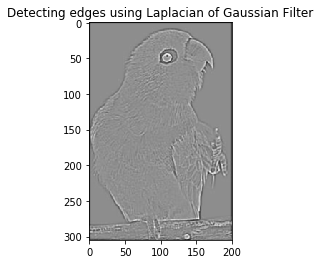

In [21]:
log = laplacian_of_gaussian(gray1, 7, 1.0)
plt.title("Detecting edges using Laplacian of Gaussian Filter")
plt.imshow(log, cmap='gray')

## Canny Edge Detection
The Canny edge detector is an edge detection operator that uses a multi-stage algorithm to detect a wide range of edges in images.</br>
This algorithm is composed of following steps:
 * Noise reduction
 * Gradient calculation
 * Non-maximum suppression
 * Thresholding

In [0]:
def normalize(image):
    minM = np.min(image)
    maxM = np.max(image)
    output = (image.astype(float) - minM) / (maxM - minM)
    return output

In [0]:
def get_gradients(image, sigma):
    image = gaussian_Blur(image, 5, sigma)
    Sx = tf.convert_to_tensor([ [-1, 0, 1], [-2, 0, 2], [-1, 0, 1] ],dtype=tf.float32)
    Sy = tf.convert_to_tensor([ [-1, -2, -1], [0, 0, 0], [1, 2, 1] ],dtype=tf.float32)
    
    image = tf.expand_dims(image,0)
    image = tf.expand_dims(image,3)
    image = tf.image.convert_image_dtype(image, tf.dtypes.float32)
    
    fil1 = tf.stack([Sx]*1, axis=2)
    fil1 = tf.expand_dims(fil1, 3)
    
    fil2 = tf.stack([Sy]*1, axis=2)
    fil2 = tf.expand_dims(fil2, 3)
    
    Ix = tf.nn.depthwise_conv2d(image, fil1, strides=[1, 1, 1, 1], padding="SAME")
    Iy = tf.nn.depthwise_conv2d(image, fil2, strides=[1, 1, 1, 1], padding="SAME")
    Ix = tf.squeeze(Ix,0)
    Ix = tf.squeeze(Ix,2)
    Iy = tf.squeeze(Iy,0)
    Iy = tf.squeeze(Iy,2)
    
    Mag = tf.sqrt(tf.add(tf.square(Ix), tf.square(Iy)))
    Mag = Mag.numpy()
    Mag = normalize(Mag)
    orient = tf.atan2(Iy, Ix).numpy()
    
    ori_new = np.zeros(orient.shape)
#     ori_new[(orient > - np.pi/8) & (orient <= np.pi/8) & (Mag>0.01)] = 0
#     ori_new[(orient > 7 * np.pi/8) & (orient <= np.pi) & (Mag>0.01)] = 0
#     ori_new[(orient >= -np.pi) & (orient < -7 * np.pi/8) & (Mag>0.01)] = 0
    
    ori_new[(orient > np.pi / 8) & (orient <= 3 * np.pi / 8) & (Mag>0.01)] = 3
    ori_new[(orient >= -7 * np.pi / 8) & (orient < -5 * np.pi / 8) & (Mag>0.01)] = 3
    
    ori_new[(orient > 3 * np.pi / 8) & (orient <= 5 * np.pi /8) & (Mag>0.01)] = 2
    ori_new[(orient >= -5 * np.pi / 4) & (orient < -3 * np.pi / 8) & (Mag>0.01)] = 2
    
    ori_new[(orient > 5 * np.pi/8) & (orient <= 7 * np.pi /8) & (Mag>0.01)] = 1
    ori_new[(orient >= -3 * np.pi / 8) & (orient < -np.pi / 8) & (Mag>0.01)] = 1
    
    return Mag, ori_new

In [0]:
def NMS(mag, orient):
    mag_new = np.zeros(mag.shape)
    for i in range(mag.shape[0] - 1):
        for j in range(mag.shape[1] - 1):
            if mag[i][j] < 0.01:
                continue
            if orient[i][j] == 0:
                di,dj = 0,-1
            elif orient[i][j] == 1:
                di,dj = -1,1
            elif orient[i][j] == 2:
                di,dj = -1,0
            elif orient[i][j] == 3:
                di,dj = -1,-1
            if mag[i][j] > mag[i+di][j+dj] and mag[i][j] >= mag[i-di][j-dj]:
                mag_new[i][j] = mag[i][j]

    return mag_new

In [0]:
def threshold(NMS):
    NMS = tf.convert_to_tensor(NMS)
    mmax = tf.math.reduce_max(NMS)
    l = 0.1 * mmax
    strong = 1.0
    nn = tf.where(NMS>l,strong,0)
    return nn

In [0]:
def canny_edge(image, sigma):
    if len(image.shape)==3 and image.shape[2]==3:
        raise TypeError('Please input Grayscaled Image.')
    elif len(image.shape)>3:
        raise TypeError('Incorrect number of channels.')
    image = normalize(image)
    mag, angle = get_gradients(image, sigma)
    non_max_sup = NMS(mag,angle)
    thresh = threshold(non_max_sup)
    return thresh

Time: 0.27112603187561035


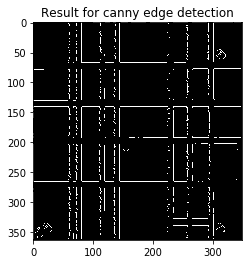

In [35]:
t0 = time.time()
canny = canny_edge(gray2.copy(), 1.0)
print("Time:",time.time()-t0)
plt.title("Result for canny edge detection")
plt.imshow(canny, cmap="gray")

## Hough Transform for Lines
Hough Transform is another technique to detect lines in any image.</br>
It creates an accumulator array for angels(slope of the edge) and lengths of the edges. Now for every non-zero pixel we generate sinusoidal in (p, Θ) space and for every p,Θ we vote in accumulator array. </br>
p = x sin(Θ) + y cos(Θ), where (p,Θ) suggests a line of length p and at an angle Θ from origin.</br>
Now we set threshold for number of votes and we will  only consider lines above that threshold.

In [0]:
def accumulator(image):
    ind = tf.where(tf.equal(image,255))
    indx = tf.dtypes.cast(tf.reshape(ind[:,0],(-1,1)), dtype=tf.float32)
    indy = tf.dtypes.cast(tf.reshape(ind[:,1],(-1,1)), dtype=tf.float32)
    thetaRange = tf.transpose(tf.reshape(tf.convert_to_tensor([i for i in range(-90,90)],dtype=tf.float32),(-1,1)))
    
    rhoCalc = tf.round(tf.matmul(indx, tf.math.cos((thetaRange*np.pi/180))) + tf.matmul(indy, tf.math.sin((thetaRange*np.pi/180))))

    rhoTheta = []
    for i in range(int(tf.math.reduce_min(rhoCalc)),int(tf.math.reduce_max(rhoCalc)+1)):
        for j in range(180):
            rhoTheta.append(tf.where(tf.equal(rhoCalc[:,j], i)).shape[0])
    rhoTheta = tf.reshape(tf.convert_to_tensor(rhoTheta),(-1,180))
    return rhoTheta.numpy(), rhoCalc.numpy()

In [0]:
def draw_lines(rhoTheta, rhoCalc, image):
    goodRho, goodTheta = np.where(rhoTheta>120)
    result = image.copy()
    indent = np.min(rhoCalc)

    for i,j in zip(goodRho, goodTheta):
        ind = np.where((goodRho>=i) & (goodRho<i+25) & (goodTheta<j+4) & (goodTheta>=j))
        if goodRho[ind].size > 0 or goodTheta[ind].size > 0:
            i = np.mean(goodRho[ind])
            j = np.mean(goodTheta[ind])

            goodRho = np.delete(goodRho, ind)
            goodTheta = np.delete(goodTheta, ind)

            xTheta = np.cos((j-90)*np.pi/180)
            yTheta = np.sin((j-90)*np.pi/180)

            for x in range(len(image)):
                y = np.round(((i + indent) - (x*xTheta))/yTheta)
                if y >= len(image[0]):
                    break
                if y>=0:
                    result[x,int(y)-2:int(y)+2] = [0,255,0]
    return result

In [0]:
def hough_lines(image):
    image = tf.image.convert_image_dtype(image, tf.dtypes.float32)
    gray = tf.image.rgb_to_grayscale(image)
    gray = tf.image.convert_image_dtype(gray, tf.dtypes.uint8)
    gray = tf.squeeze(gray,2)
    gradimg = canny_edge(gray.numpy(),1.0)
    gradimg = tf.cast(gradimg*255.0,dtype=np.int32)
    rhoTheta, rhoCalc = accumulator(gradimg)
    result = draw_lines(rhoTheta, rhoCalc, image.numpy())
    return result

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
W0821 22:17:08.297424 140608124503936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


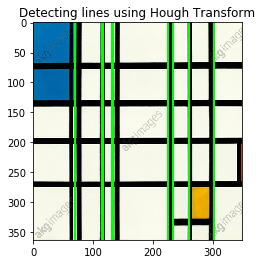

In [39]:
hough = hough_lines(color2.copy())
plt.title("Detecting lines using Hough Transform")
plt.imshow(hough)

## Hough Transform for Circles
Hough Transform is a technique to detect circles in any image.</br>
Circle can be defined by 3 parameters center (a,b) and radius r. The set of all the possible circles is defined by all the possible values for a, b and r. And for each circle, the pixels that belong to the circle can be found by iterating over some possible values between (0, 2π).  

In [0]:
def draw_circle(x0, y0, radius, image):
    x = radius
    y = 0
    decisionOver2 = 1 - x

    while x >= y:
        image[x + x0, y + y0] = [0,255,0]
        image[y + x0, x + y0] = [0,255,0]
        image[-x + x0, y + y0] = [0,255,0]
        image[-y + x0, x + y0] = [0,255,0]
        image[-x + x0, -y + y0] = [0,255,0]
        image[-y + x0, -x + y0] = [0,255,0]
        image[x + x0, -y + y0] = [0,255,0]
        image[y + x0, -x + y0] = [0,255,0]
        y+=1
        if decisionOver2 <= 0:
            decisionOver2 += 2 * y + 1
        else:
            x-=1
            decisionOver2 += 2 * (y - x) + 1
    return image

In [0]:
def plot_circles(accumulator, image, csize, radius):
    rows, cols = image.shape[:2]
    max_pool = np.zeros((radius,csize,csize))

    for i in range(0,rows-csize,csize):
        for j in range(0,cols-csize,csize):
            max_pool[:,:,:]=1
            max_pool=accumulator[:,i:i+csize,j:j+csize]*max_pool
            max_val=np.where(max_pool==max_pool.max())

            r = max_val[0][0]
            x = max_val[1][0]       
            y = max_val[2][0]
            if max_pool.max()>0.6:
                accumulator[:,i:i+csize,j:j+csize]=accumulator[:,i:i+csize,j:j+csize]/accumulator[r][x+i][y+j]
                for r in range(10,radius):
                    for q in range(i,i+csize):
                        for w in range(j,j+csize):
                            if accumulator[r][q][w]>0.9:
                                image = draw_circle(q,w,r,image)
    return image

In [0]:
def hough_circle(image):
    image = tf.image.convert_image_dtype(image, tf.dtypes.float32)
    gray = tf.image.rgb_to_grayscale(image)
    gray = tf.image.convert_image_dtype(gray, tf.dtypes.int32)
    gray = tf.squeeze(gray,2)
    
    edge = canny_edge(gray.numpy(),1.0)
    edge = tf.cast(edge*255.0,dtype=np.int32)
    radius = int(min(image.shape[0],image.shape[1])/3)
    rows, cols = gray.shape
    
    ind = tf.where(tf.equal(edge, 255))
    radius = int(tf.math.minimum(tf.math.minimum(tf.math.reduce_max(ind[:,0])- tf.math.reduce_min(ind[:,0]), tf.math.reduce_max(ind[:,1]) - tf.math.reduce_min(ind[:,1]))/2,radius))
    
    print("Max Radius : ",radius)
    
    accumulator = np.zeros((radius,rows,cols))
    theta = tf.convert_to_tensor([t for t in range(0,360,10)],dtype=tf.float32)
    theta = tf.transpose(tf.stack([theta]*len(ind[:,0]))*(np.pi/180))
    
    cs = tf.math.cos(theta).numpy()
    sn = tf.math.sin(theta).numpy()
    xo1 = tf.cast(tf.stack([ind[:,0]]*36), dtype=tf.float32).numpy()
    yo1 = tf.cast(tf.stack([ind[:,1]]*36), dtype=tf.float32).numpy()

    for r in range(10,radius):  
        a1 = (xo1 - r*cs).astype(int)
        a2 = (yo1 - r*sn).astype(int)
        inx = ((a1>0) & (a1<rows) & (a2 >0) & (a2<cols))
        b1 = a1[inx]
        b2 = a2[inx]
        for i in range(len(b1)):
            accumulator[r][b1[i]][b2[i]] += 1
              
    accumulator = accumulator / np.amax(accumulator)
    csize=30
    
    final = plot_circles(accumulator, image.numpy(), csize, radius)
    return final

Max Radius :  120


W0821 22:18:00.540114 140608124503936 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


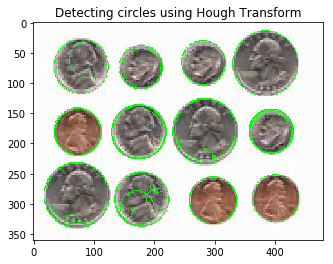

In [43]:
c_hough = hough_circle(color3.copy())
plt.title("Detecting circles using Hough Transform")
plt.imshow(c_hough)

## SIFT Feature Detector
The scale-invariant feature transform (SIFT) used to detect and describe local features in images.
This algorithm is divided in 4 steps:
1. keypoint detection
2. keypoint localization
3. orientation assignment
4. keypint descriptor

In [0]:
def scaleSpace(image, numOctave, sn, kf, constFactor, sigma):
    im = gaussian_Blur(image, 10, 1)
    scaleList = []
    for i in range(sn):
        newArr = gaussian_Blur(im, 10, sigma * kf**i)
        scaleList.append(newArr)

    factor = 0
    for j in range(3):
        for i in range(3):
            scaleList.append(scaleList[-3][::2, ::2])
        for i in range(factor, factor+2):
            newSig = kf**i * constFactor * sigma
            newArr = gaussian_Blur(scaleList[-1], 10, newSig)
            scaleList.append(newArr)
        
    return scaleList, im

In [0]:
def DifferenceofGaussian(scaleList, numOctave, sn):
    DoG = []
    for oc in range(numOctave):
        for i in range(sn - 1):
            DoG.append(tf.subtract(scaleList[i+1+oc*sn], scaleList[i+oc*sn]).numpy())
    return DoG

In [0]:
def localExtrema(DoG, numOctave, sn):
    extrema = []
    for oc in range(numOctave):
        m, n = DoG[oc*(sn-1)].shape
        for i in range(1,3):
            for x in range(1,m):
                for y in range(1,n):
                    flag = True
                    neighbors = np.array([DoG[j+oc*(sn-1)][x-1:x+2,y-1:y+2] for j in range(i-1,i+2)]).ravel()
                    neighbors = np.delete(neighbors, len(neighbors)/2)
                    sign = np.sign(neighbors[0] - DoG[i+oc*(sn-1)][x,y])
                    for num in neighbors[1:]:
                        if (np.sign(num - DoG[i+oc*(sn-1)][x,y]) != sign):
                            flag = False
                            break
                    if flag:
                        extrema.append([2**oc*x, 2**oc*y])
                
    return np.array(extrema)

In [0]:
def siftfearures(image):
    kf = np.sqrt(2)
    constFactor = np.sqrt(kf**2 - 1)
    sigma = 2
    sn = 5
    numOctave = 4
    
    scaleList, im = scaleSpace(image, numOctave, sn, kf, constFactor, sigma)
    DoG = DifferenceofGaussian(scaleList, numOctave, sn)
    extrema = localExtrema(np.array(DoG), numOctave, sn)
    return extrema

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: using a non-integer array as obj in delete will result in an error in the future
  # Remove the CWD from sys.path while we load stuff.


Time:  21.223626375198364


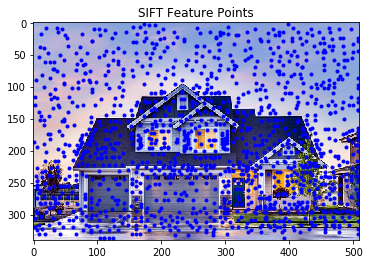

In [68]:
t0 = time.time()
featurepoints = siftfearures(gray5)
print("Time: ",time.time()-t0)
plt.title("SIFT Feature Points")
plt.imshow(color5, cmap='gray')
plt.plot(featurepoints[:,1], featurepoints[:,0],'b.')

## Grab Cut
This operation allows user to segment the image and try to obtain the foreground of the image.</br>
It takes input as image and coordinates of the bounding box which gives the information that region outside the bounding box is sure background and the region inside the bounding box is unknown.

In [0]:
def energy(rgb, height, width):
    gamma = 50
    shiftN = rgb[1:height,:]-rgb[:height-1,:]
    dis_N = np.sum(np.multiply(shiftN,shiftN),axis=2).flatten()

    shiftW = rgb[:,1:width]-rgb[:,:width-1]
    dis_W = np.sum(np.multiply(shiftW,shiftW),axis=2).flatten()

    shiftNW = rgb[1:height,1:width]-rgb[:height-1,:width-1]
    dis_NW = np.sum(np.multiply(shiftNW,shiftNW),axis=2).flatten()

    shiftNE = rgb[1:height,:width-1]-rgb[:height-1,1:width]
    dis_NE = np.sum(np.multiply(shiftNE,shiftNE),axis=2).flatten()

    beta = 1/(2*(np.sum(dis_N)+np.sum(dis_W)+np.sum(dis_NE)+np.sum(dis_NW))/(4*height*width - 3*height - 3*width + 2))

    a = np.zeros([height,width])
    a[1:height,:] = 1
    a = a.flatten()
    b = np.zeros([height, width])
    b[:height-1,:] = 1
    b = b.flatten()

    es = np.column_stack([np.where(a==1)[0], np.where(b==1)[0]])
    w = gamma*np.exp(-beta*dis_N)

    a = np.zeros([height, width])
    a[:,1:width] = 1
    a = a.flatten()
    b = np.zeros([height, width])
    b[:,:width-1] = 1
    b = b.flatten()

    es_temp = np.column_stack([np.where(a == 1)[0], np.where(b == 1)[0]])
    es = np.row_stack([es,es_temp])
    w = np.append(w,gamma * np.exp(-beta * dis_W))

    a = np.zeros([height, width])
    a[1:height,1:width] = 1
    a = a.flatten()
    b = np.zeros([height, width])
    b[:height-1,:width-1] = 1
    b = b.flatten()

    es_temp = np.column_stack([np.where(a == 1)[0], np.where(b == 1)[0]])
    es = np.row_stack([es,es_temp])
    w = np.append(w, gamma/2**0.5 * np.exp(-beta * dis_NW))

    a = np.zeros([height, width])
    a[1:height,:width-1] = 1
    a = a.flatten()
    b = np.zeros([height, width])
    b[:height-1,1:width] = 1
    b = b.flatten()

    es_temp = np.column_stack([np.where(a == 1)[0], np.where(b == 1)[0]])
    es = np.row_stack([es,es_temp])
    w = np.append(w, gamma/2**0.5 * np.exp(-beta * dis_NE))
    return w, es

In [0]:
def mincut(w, es, height, width):
    cuts = igraph.Graph()
    cuts.es['weight'] = 1
    cuts.add_vertices(height * width + 2)
    cuts.add_edges(es)
    cuts.es['weight'] = w

    c = cuts.mincut(width * height, width * height+1, capacity='weight')
    return c

In [0]:
def grabcut_algo(rgb,T):
    width = rgb.shape[1]
    height = rgb.shape[0]
    gamma = 50
    w, es = energy(rgb, height, width)

    K_temp=np.zeros([width*height])
    T_temp=T.flatten()
    rgb_temp = rgb.reshape([width * height, 3])
    Tb=T_temp==0 #Sure background
    Tf=T_temp==3 #Sure foreground
    Tu=(T_temp==1)|(T_temp==2) # unknown

    if any(Tb):
        es_temp = np.column_stack([np.where(Tb)[0], (width * height) * np.ones(Tb[Tb].shape)])
        es = np.row_stack([es, es_temp])
        w_temp = 9 * gamma * np.ones(Tb[Tb].shape)
        w = np.append(w, w_temp)

        es_temp = np.column_stack([np.where(Tb)[0], (width * height + 1) * np.ones(Tb[Tb].shape)])
        es = np.row_stack([es, es_temp])
        w_temp = np.zeros(Tb[Tb].shape)
        w = np.append(w, w_temp)

    Tb=T_temp<2
    Tf=T_temp>1

    gmm = [GaussianMixture(n_components=5),GaussianMixture(n_components=5)]
    K_temp[Tb]=gmm[0].fit_predict(rgb_temp[Tb])
    K_temp[Tf]=gmm[1].fit_predict(rgb_temp[Tf])

    es_temp = np.column_stack([np.where(Tu)[0], (width*height) * np.ones(Tu[Tu].shape)])
    es = np.row_stack([es, es_temp])
    w_temp = -gmm[1].score(rgb_temp[Tu])
    w = np.append(w, w_temp)

    es_temp = np.column_stack([np.where(Tu)[0], (width*height+1)* np.ones(Tu[Tu].shape)])
    es = np.row_stack([es, es_temp])
    w_temp = -gmm[0].score(rgb_temp[Tu])
    w = np.append(w, w_temp)

    es = es.astype(int)
    c = mincut(w, es, height, width)

    indexb = np.array(list(c[0]),dtype=int)
    indexb = indexb[indexb<width*height]
    indexf = np.array(list(c[1]),dtype=int)
    indexf = indexf[indexf<width*height]

    T_temp[indexb]=1
    T_temp[indexf]=2

    rgb_temp[T_temp<2]=(255,255,255)
    final = rgb_temp.reshape([height,width,3])
    final = np.array(final,dtype=np.uint8)
    return final

In [0]:
def GrabCut(image,pos1x, pos1y, pos2x, pos2y):
    img = np.array(image,dtype=np.float)
    mask = np.zeros(img.shape[:2],np.uint8) 
    height = img.shape[0]
    width = img.shape[1]
    pos1x = width-1 if pos1x>width-1 else pos1x
    pos1y = height-1 if pos1y>height-1 else pos1y
    pos2x = width-1 if pos2x>width-1 else pos2x
    pos2y = height-1 if pos2y>height-1 else pos2y

    mask[pos1y:pos2y+1,pos1x:pos2x+1]=3

    mask1 = np.zeros(img.shape[:2],np.uint8)
    mask1[mask==1] = 3
    mask1[mask==2] = 1
    mask1[mask==3] = 2
    segment = grabcut_algo(img, mask1)
    return segment

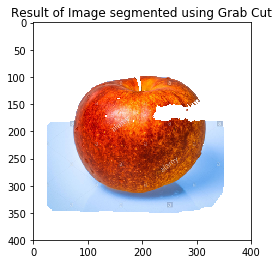

In [46]:
grab = GrabCut(color4,25,25,350,350)
plt.title("Result of Image segmented using Grab Cut")
plt.imshow(grab)